Notebook for Problem Set 4
- **Authors:** Erin Silver, Sarah Grobe, Sarah Niknaum
- **Term:** Spring 2023
- **License:** GPL-3

In [4]:
'Network tools and basic functions for later use. Clean up regularly.'

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import ipywidgets as widgets
import random

# 1. Linear Rankings

## Data Acquisition

In [53]:
def load_nodes(G, filename):
    '''Loads nodes, metadata.'''
    vert_f = open(filename, 'r')
    vert_l = vert_f.readlines()[1:] # Skip header
    for v in vert_l:
        vert = v.rstrip('\n').split(',')
        pos_0 = float(vert[1].lstrip('"array(['))
        pos_1 = float(vert[2].lstrip(' ').rstrip('"])""'))
        pos = (pos_0, pos_1)
        G.add_node(vert[0], pos=pos)

def load_edges(G, filename):
    '''Loads edges, metadata.'''
    edge_f = open(filename, 'r')
    edge_l = edge_f.readlines()[1:] # Skip header
    for e in edge_l:
        edge = e.rstrip('\n').split(',')  
        G.add_edge(edge[0], edge[1])

def load_csv(G, location):
    fn_nodes = location + '\\nodes.csv'
    fn_edges = location + '\edges.csv'
    load_nodes(G, fn_nodes)
    load_edges(G, fn_edges) 

In [54]:
G = nx.DiGraph()
load_csv(G, 'papuan')

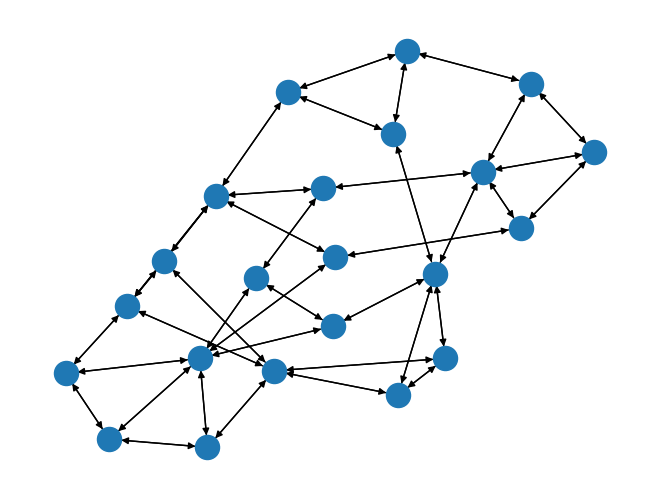

In [56]:
pos = nx.get_node_attributes(G, "pos")
nx.draw(G, pos)

While this network is directed, all relationships appear to be reciprocal.

In [113]:
def get_katz_cent(G, a = 0.1):
    A = nx.adjacency_matrix(G).todense()
    n = A.shape[0]
    I = np.eye(n)
    centrality = np.matmul(np.linalg.inv(I - a*A), np.ones((n, 1)))
    return centrality.flatten()


In [114]:
def get_eigen_cent(G):
    A = nx.adjacency_matrix(G).todense()
    e_vals, e_vecs = np.linalg.eig(A)
    # get index of largest eigenvalue to pass and find matching eigenvector
    max_idx = np.argmax(e_vals)
    v = e_vecs[:, max_idx].real
    return v / np.sum(v)

In [116]:
def get_pr_cent(G, a = 0.85, max_iter = 100, tol = 1e-6):
    A = nx.adjacency_matrix(G).todense()
    n = A.shape[0]
    out_degree = np.sum(A, axis=1)
    P = A / out_degree[:, np.newaxis]
    v = np.ones(n) / n
    r = v.copy()

    for i in range(max_iter):
        r_new = a * P.T @ r + (1 - a) * v
        if np.linalg.norm(r_new - r) < tol:
            break
        r = r_new
    return r

In [128]:
custom_katz = get_katz_cent(G)
nx_katz = list(nx.katz_centrality(G).values())

const_katz = [(custom_katz[n] / nx_katz[n]) for n in range(len(G.nodes()))]
print(const_katz)

var_katz = np.var(const_katz)
print(var_katz)

[7.382650085677936, 7.382650007085795, 7.382650265585512, 7.3826503115338, 7.382650049948975, 7.382650209664897, 7.382650085827706, 7.382650135075992, 7.382649992034732, 7.382649992034732, 7.382649642261193, 7.382649968670023, 7.382649889934146, 7.382649483462006, 7.382649632184217, 7.382649582477576, 7.382650089142744, 7.382649943229882, 7.382650016348572, 7.382649633907334, 7.382649719136174, 7.382649945925874]
5.0585355182376815e-14


In [129]:
custom_eigen = get_eigen_cent(G)
nx_eigen = list(nx.eigenvector_centrality(G).values())

const_eigen = [(custom_eigen[n] / nx_eigen[n]) for n in range(len(G.nodes()))]
print(const_eigen)

var_eigen = np.var(const_eigen)
print(var_eigen)

[0.22150403640990945, 0.22150528557298005, 0.22150067869943557, 0.22150299578163132, 0.2215045204517997, 0.2215016002295035, 0.22150073898473957, 0.22149800281970647, 0.22149650079789251, 0.22149650079789251, 0.2214914138574466, 0.22149814242070062, 0.22149382248335814, 0.2214844055760559, 0.22148858589667572, 0.22148101526992142, 0.22149244149861608, 0.22148607202619375, 0.2214990262769256, 0.2214818543319678, 0.22148718964470812, 0.22149998876170812]
5.443066722605078e-11


In [130]:
custom_pr = get_pr_cent(G)
nx_pr = list(nx.pagerank(G).values())

const_pr = [(custom_pr[n] / nx_pr[n]) for n in range(len(G.nodes()))]
print(const_pr)

var_pr = np.var(const_pr)
print(var_pr)

[1.0000328744073836, 1.0000265609523504, 1.000013258955963, 1.000016008028193, 1.0000281663661126, 1.0000214941495686, 1.0000211974318187, 0.9999927538115194, 1.000013179222355, 1.000013179222355, 0.999983006951077, 1.0000073785338446, 0.9999989251081767, 0.9999664349632821, 0.9999786827405732, 0.9999650667993023, 0.9999900929002526, 0.9999752911927652, 1.0000153884792615, 0.9999698907823877, 0.9999709997092293, 1.0000056677908598]
4.632896676095106e-10


As the above variances in scalar difference between the custom and NetworkX functions are exceedingly small, we determine they are within reasonable error bounds.